In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from scipy.stats import ttest_ind
from scipy.stats import linregress
import statsmodels.api as sm
from sklearn.impute import KNNImputer
import seaborn as sn
from fuzzywuzzy import process
import itertools
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
import imgkit

In [33]:
df = pd.read_excel('Dataset spreadsheet.xlsx')

In [34]:

html_str = df.head().to_html()

# Save the HTML to an image

In [35]:
basic_stats = df.describe()
print(f"Basic Statistics: \n{basic_stats}\n")

Basic Statistics: 
             TemP  Time (min)          PS          BET         PV          C  \
count   86.000000   86.000000   85.000000    86.000000  85.000000  83.000000   
mean   566.453488  151.347287   13.908847   191.444442   0.152331  57.293855   
std    170.921148  126.607738   38.958862   298.769825   0.180884  20.399065   
min    300.000000    0.100000    1.320000     0.479000   0.001000   9.460000   
25%    450.000000   60.000000    2.880000     7.100000   0.020000  41.490000   
50%    500.000000  120.000000    4.440000    59.090000   0.100000  60.000000   
75%    700.000000  150.000000    9.850000   295.500000   0.230000  74.195000   
max    950.000000  480.000000  213.290000  1838.860000   1.030000  89.570000   

               H          O  
count  82.000000  83.000000  
mean    1.927890  16.469048  
std     1.648728  11.025043  
min     0.000000   0.670000  
25%     0.834000  10.100000  
50%     1.630000  14.030000  
75%     2.622500  21.755000  
max    10.300000  55

In [36]:
df.isna().sum()

Biomass       1
TP            0
TemP          0
Time (min)    0
PS            1
BET           0
PV            1
C             3
H             4
N             6
O             3
Qm (mg/g)     0
dtype: int64

In [37]:
df.dtypes

Biomass        object
TP             object
TemP            int64
Time (min)    float64
PS            float64
BET           float64
PV            float64
C             float64
H             float64
N              object
O             float64
Qm (mg/g)      object
dtype: object

In [38]:
#converting object to float for N , Qm (mg/g) variables
df['N'] = pd.to_numeric(df['N'], errors='coerce')
df['Qm (mg/g)'] = pd.to_numeric(df['Qm (mg/g)'] , errors='coerce')

In [42]:
# Define numeric columns
numeric_columns = ['TemP', 'Time (min)', 'PS', 'BET', 'PV', 'C', 'N', 'H', 'O', 'Qm (mg/g)']

df[numeric_columns] = df[numeric_columns].interpolate(method='linear', limit_direction='forward', axis=0)



In [43]:
df.isna().sum()

Biomass       1
TP            0
TemP          0
Time (min)    0
PS            0
BET           0
PV            0
C             0
H             0
N             0
O             0
Qm (mg/g)     0
dtype: int64

In [44]:
df[df['Biomass'].isnull()]

,Biomass,TP,TemP,Time (min),PS,BET,PV,C,H,N,O,Qm (mg/g)
70,NaN,Tetracycline,600.0,60.0,3.82,319.8,0.54,73.35,2.57,2.57,0.67,157.69


In [45]:
# Forward fill the Biomass column because Sludge (pharmaceutical) is shared with two rows.
df['Biomass'] = df['Biomass'].fillna(method='ffill')
df[df['Biomass'].isnull()]


,Biomass,TP,TemP,Time (min),PS,BET,PV,C,H,N,O,Qm (mg/g)


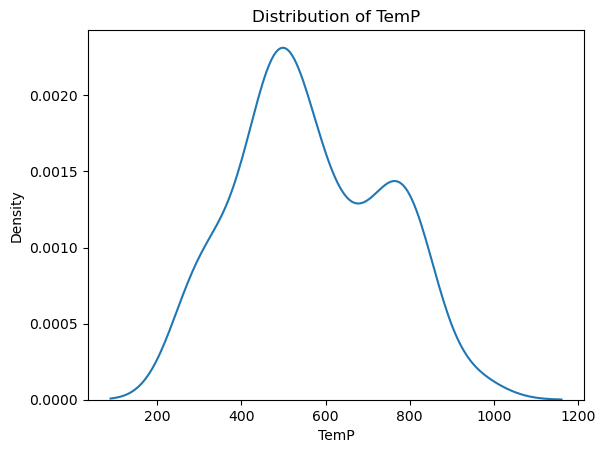

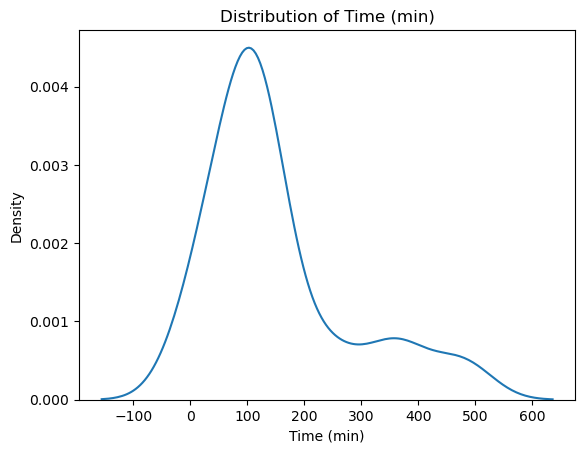

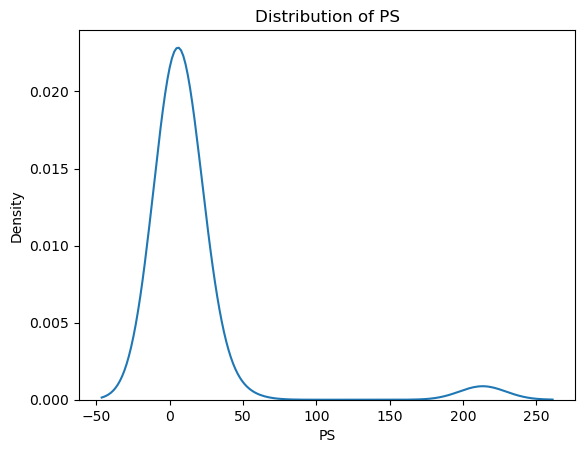

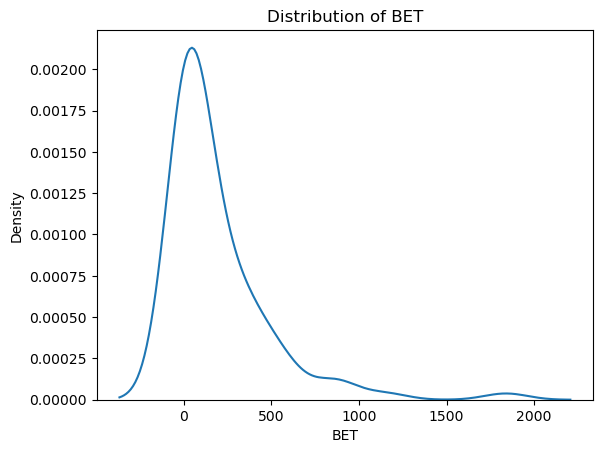

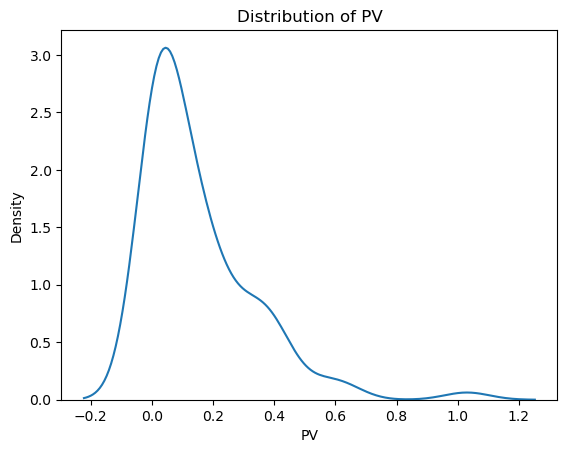

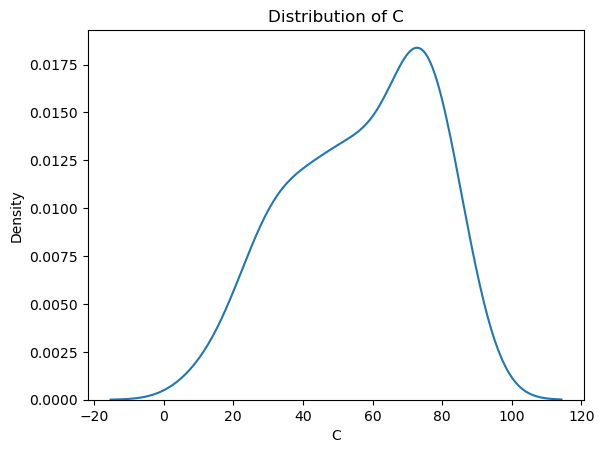

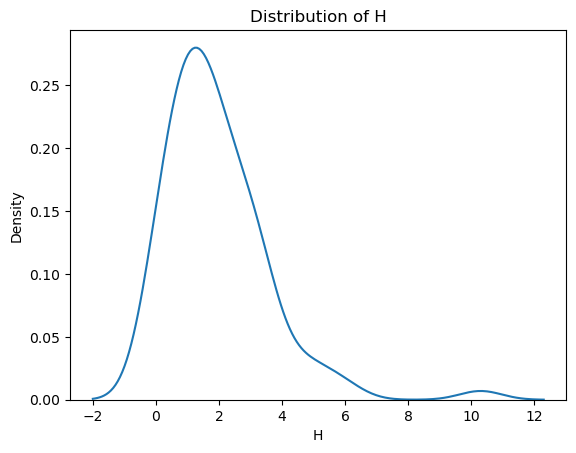

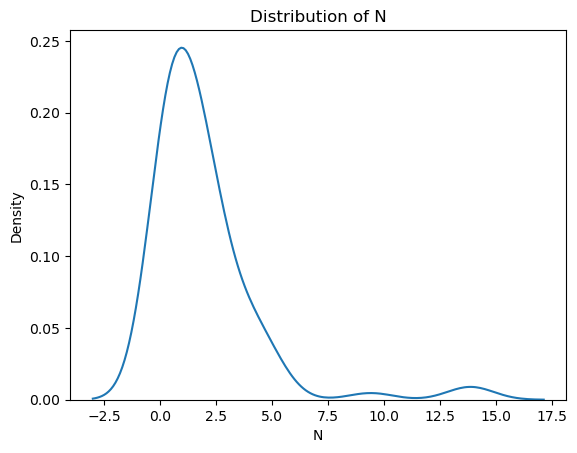

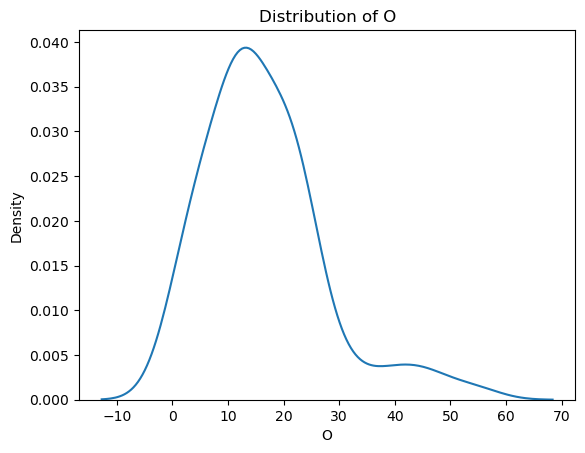

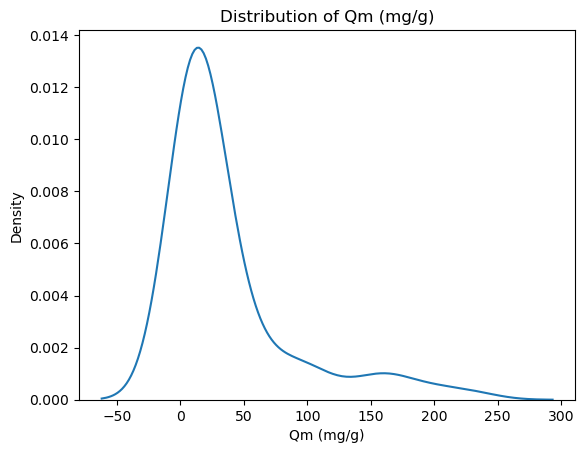

In [46]:
# Plot distributions of the features
def distplots(df):
    for col in df.columns:
        if df[col].dtype != object:
            if df[col].dtype == np.float64:
                sn.kdeplot(df[col])
            elif df[col].dtype == np.int64:
                sn.histplot(df[col])
            plt.title(f"Distribution of {col}")
            plt.show()
distplots(df)

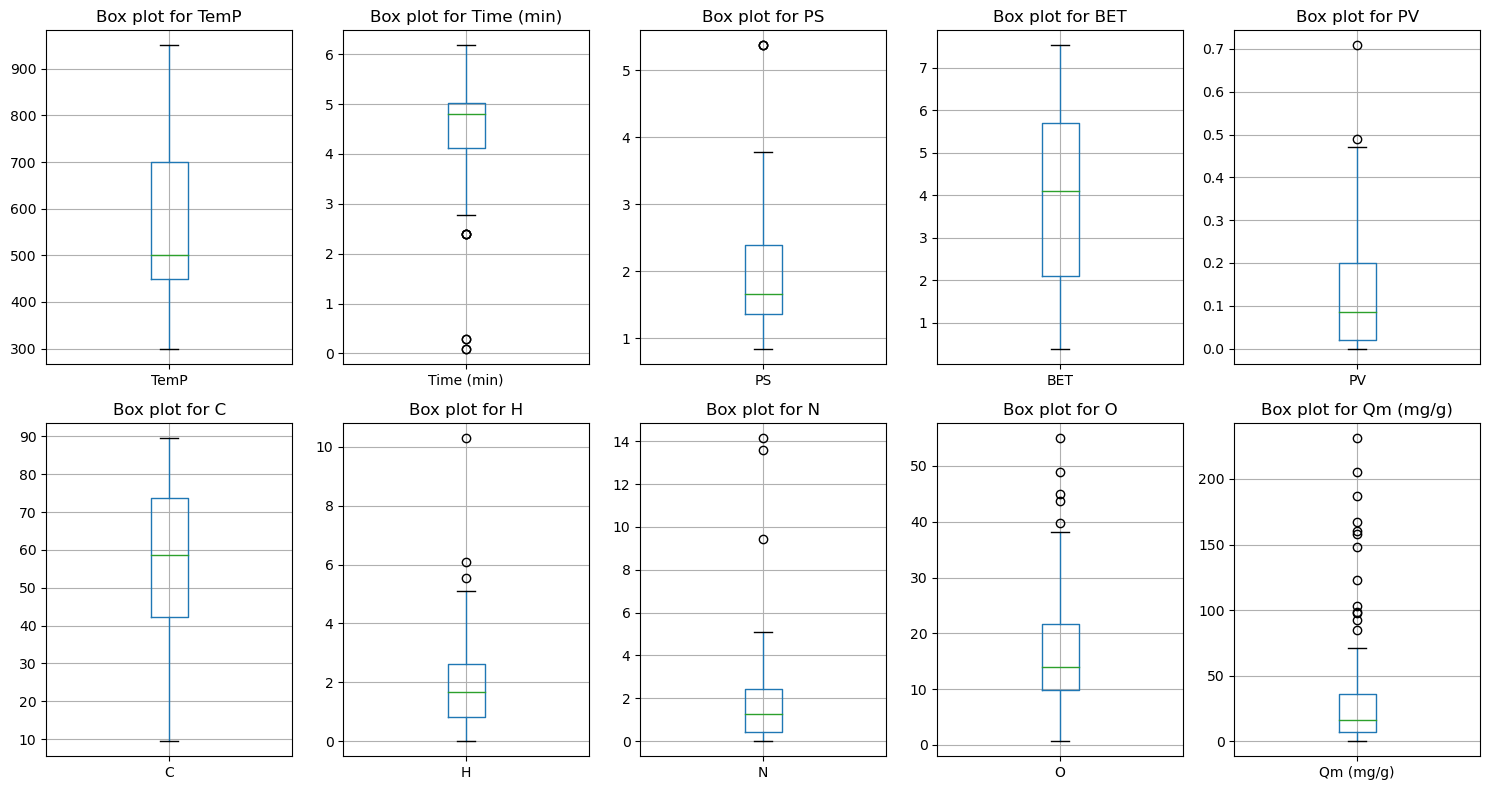

In [83]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 8))  # Adjust rows and columns as needed
axes = axes.flatten()  # Flatten the 2D axes array to make indexing easier

# List of columns to plot
columns = ['TemP', 'Time (min)', 'PS', 'BET', 'PV', 'C', 'H', 'N', 'O' , 'Qm (mg/g)']

# Loop through the columns and plot each one in a separate subplot
for i, column in enumerate(columns):
    df.boxplot(column=column, ax=axes[i])
    axes[i].set_title(f'Box plot for {column}')
    axes[i].set_xlabel('')

# Adjust layout
plt.tight_layout()
plt.savefig('boxplots_figure.png', dpi=300, bbox_inches='tight')  # Save as PNG with high resolution

# Display the figure
plt.show()


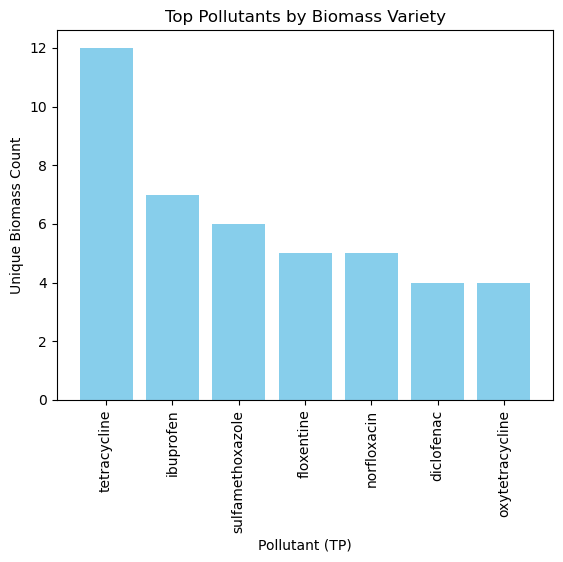

In [47]:
#removing spaces & converting into lower case
df['TP'] = df['TP'].str.strip().str.lower()
#grouping to see one pollutant is absorbed by different biomass.
TP_biomass = df.groupby('TP')['Biomass'].nunique().sort_values(ascending = False).reset_index().head(7)
plt.bar(TP_biomass['TP'], TP_biomass['Biomass'], color = 'skyblue')
plt.xlabel('Pollutant (TP)')
plt.ylabel('Unique Biomass Count')
plt.title('Top Pollutants by Biomass Variety')
plt.xticks(rotation=90)
plt.savefig("Top_5_Pollutants_by_Biomass_Variety.png", bbox_inches='tight')

In [48]:
#Biomass source classification
def process_biomass(biomass):
    biomass = biomass.lower()
    biomass = re.sub(r'[^\w\s]', '', biomass)  # Removes punctuation and special characters
    # Extract the last word
    last_word = biomass.split()[-1] 
    return last_word
df['raw_material'] = df['Biomass'].apply(process_biomass)
# Normalize 'Processed_Biomass' to count 'plant' and 'plants' as the same
df['raw_material'] = df['raw_material'].replace({'plants': 'plant'})


In [49]:
df = df.drop('Biomass', axis = 1)

In [16]:
df.to_csv('Updated_dataset.csv') 

In [50]:
# Group by 'raw_materials' and count occurrences
grouped_counts = df.groupby('raw_material').size().sort_values(ascending = False).reset_index(name='Count')
html_str = grouped_counts.head(10).to_html(index=False)
grouped_counts


,raw_material,Count
0,biochar,9
1,straw,8
2,fecl3,7
3,manure,6
4,plant,5
5,waste,4
6,leaves,4
7,paper,3
8,sawdust,3
9,biological,3


In [51]:
unique_raw_materials = df['raw_material'].unique()
print(unique_raw_materials)

['paper' 'biological' 'pinewood' 'plant' 'stalk' 'leaves' 'waste' 'straw'
 'sawdust' 'hysterophorus' 'sludge' 'clay' 'activation' 'feathers'
 'biochar' 'roots' 'shell' 'dealbata' 'manure' 'eucalypus' 'tree' 'quince'
 'vine' 'microalgae' 'alfalfa' 'fecl3' 'grounds' 'chips' 'natan'
 'sediment' 'malaianus' 'crispus' 'pharmaceutical' 'pristine']


In [52]:
#calculating correlation using pandas , pearson method
df_to_impute.corr(method='pearson') #only 'BET' & 'PV' columns are co-related

,TemP,Time (min),PS,BET,PV,C,N,H,O,Qm (mg/g)
TemP,1.000000,-0.120235,-0.181203,0.337013,0.179159,0.069188,0.057891,-0.367776,-0.289977,0.305999
Time (min),-0.120235,1.000000,-0.084362,-0.055130,0.031460,0.196529,-0.078409,0.015338,-0.018591,-0.125495
PS,-0.181203,-0.084362,1.000000,-0.154380,-0.141089,-0.048110,0.114764,0.128846,0.262212,0.020210
BET,0.337013,-0.055130,-0.154380,1.000000,0.789717,0.296669,0.152031,-0.114989,-0.056954,0.473991
PV,0.179159,0.031460,-0.141089,0.789717,1.000000,0.174309,0.280528,-0.067787,-0.047678,0.474331
C,0.069188,0.196529,-0.048110,0.296669,0.174309,1.000000,0.018156,0.189934,-0.026603,-0.056993
N,0.057891,-0.078409,0.114764,0.152031,0.280528,0.018156,1.000000,0.321310,-0.100710,0.292544
H,-0.367776,0.015338,0.128846,-0.114989,-0.067787,0.189934,0.321310,1.000000,0.228487,-0.023720
O,-0.289977,-0.018591,0.262212,-0.056954,-0.047678,-0.026603,-0.100710,0.228487,1.000000,0.021729
Qm (mg/g),0.305999,-0.125495,0.020210,0.473991,0.474331,-0.056993,0.292544,-0.023720,0.021729,1.000000


<Axes: >

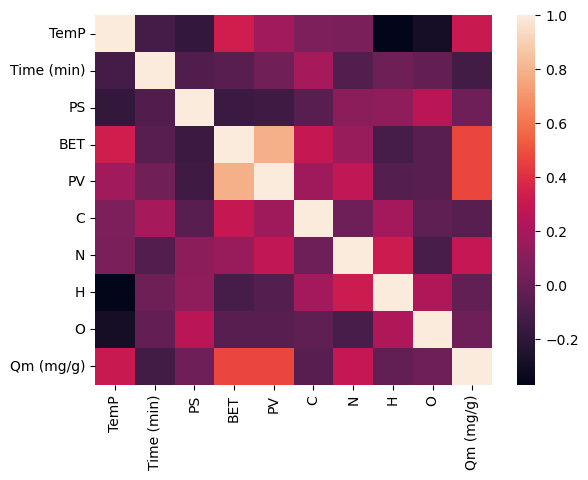

In [53]:
sn.heatmap(data = df_to_impute.corr())

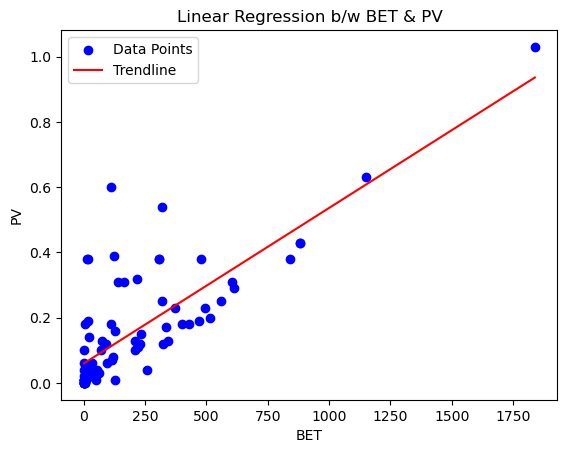

In [54]:
# Perform linear regression on the BET and PV columns
slope, intercept, r_value, p_value, std_err = linregress(df['BET'], df['PV'])

# Generate x values (BET) for plotting the regression line
x_values = np.linspace(df['BET'].min(), df['BET'].max(), 100)
# Calculate y values (PV) based on the regression equation
y_values = slope * x_values + intercept

#scatter plot
plt.scatter(df['BET'], df['PV'], label='Data Points', color='blue')

#trendline
plt.plot(x_values, y_values, color='red', label='Trendline')

# Add labels and legend
plt.xlabel('BET')
plt.ylabel('PV')
plt.title('Linear Regression b/w BET & PV')
plt.legend()
plt.savefig("BET & PV")

In [55]:
# Plot pairplot to create scatter plots between all numerical variables
sn.pairplot(df[numeric_columns])

# Display the plot
plt.show()

/Users/nandipatioohasripriya/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


KeyboardInterrupt: 

In [56]:
len(df['raw_material'].unique())

34

In [57]:
len(df['TP'].unique())

17

In [58]:
le = LabelEncoder()
df['Biomass_encoded'] = le.fit_transform(df['raw_material'])
df['TP_encoded'] = le.fit_transform(df['TP'])
print(df[['raw_material', 'Biomass_encoded', 'TP', 'TP_encoded']].head())


  raw_material  Biomass_encoded          TP  TP_encoded
0        paper               18  citalopram           2
1        paper               18  citalopram           2
2        paper               18  citalopram           2
3   biological                3  citalopram           2
4   biological                3  citalopram           2


In [59]:
df = df.drop([ 'TP' , 'raw_material' , 'TP_encoded'], axis=1)


In [60]:
df

,TemP,Time (min),PS,BET,PV,C,H,N,O,Qm (mg/g),Biomass_encoded
0,315.0,150.0,9.82,3.43,0.02,30.84,2.14,0.43,20.32,4.40,18
1,600.0,10.0,1.37,94.39,0.06,30.69,0.96,0.32,20.41,3.80,18
2,800.0,10.0,1.37,120.86,0.08,28.81,0.47,0.33,19.29,8.50,18
3,800.0,150.0,1.41,209.12,0.13,27.05,0.82,0.33,9.73,19.60,3
4,800.0,10.0,3.69,10.82,0.02,35.35,0.72,2.47,2.01,4.30,3
...,...,...,...,...,...,...,...,...,...,...,...
81,300.0,60.0,213.29,28.13,0.03,48.13,1.53,1.00,48.96,37.80,2
82,700.0,60.0,1.32,513.00,0.20,62.27,0.00,0.00,24.01,10.51,2
83,700.0,60.0,1.32,342.00,0.13,46.13,0.00,0.00,32.25,13.87,2
84,800.0,300.0,2.25,841.00,0.38,68.27,1.24,0.88,12.39,70.80,2


In [61]:

df['Time (min)'] = np.log(df['Time (min)'] + 1)  # Add 1 to avoid log(0)
df['BET'] = np.log(df['BET'] + 1)
df['PV'] = np.log(df['PV'] + 1)
df['PS'] = np.log(df['PS'] + 1) 

In [62]:
# Define X (features) and y (target)
X = df.drop(columns=['Qm (mg/g)'])  # Drop target column
y = df['Qm (mg/g)']  # Target column

In [63]:
X

,TemP,Time (min),PS,BET,PV,C,H,N,O,Biomass_encoded
0,315.0,5.017280,2.381396,1.488400,0.019803,30.84,2.14,0.43,20.32,18
1,600.0,2.397895,0.862890,4.557974,0.058269,30.69,0.96,0.32,20.41,18
2,800.0,2.397895,0.862890,4.802873,0.076961,28.81,0.47,0.33,19.29,18
3,800.0,5.017280,0.879627,5.347679,0.122218,27.05,0.82,0.33,9.73,3
4,800.0,2.397895,1.545433,2.469793,0.019803,35.35,0.72,2.47,2.01,3
...,...,...,...,...,...,...,...,...,...,...
81,300.0,4.110874,5.367330,3.371769,0.029559,48.13,1.53,1.00,48.96,2
82,700.0,4.110874,0.841567,6.242223,0.182322,62.27,0.00,0.00,24.01,2
83,700.0,4.110874,0.841567,5.837730,0.122218,46.13,0.00,0.00,32.25,2
84,800.0,5.707110,1.178655,6.735780,0.322083,68.27,1.24,0.88,12.39,2


In [64]:
#Import packages
from sklearn.metrics import accuracy_score
import xgboost as xgb
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import openpyxl
import math
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error,  make_scorer
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import cross_val_score, KFold, cross_validate, cross_val_predict
from random import randint
import warnings
import seaborn as sns
warnings.filterwarnings('ignore') 
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.exceptions import ConvergenceWarning # Import ConvergenceWarning
from joblib import parallel_backend
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer, mean_absolute_percentage_error

In [65]:
scoring = ['neg_mean_absolute_error', 'neg_mean_squared_error'] #Our major scorings

# Untuned Randomforest Regressor  

In [66]:
mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)

# Untuned Cross-Validation with MAPE
default_rf = RandomForestRegressor(random_state=42)
k_folds = KFold(n_splits=5)

untuned_mape_result = cross_val_score(default_rf, X, y.values.ravel(), cv=k_folds, scoring=mape_scorer)
untuned_rmse_result = cross_val_score(default_rf, X, y.values.ravel(), cv=k_folds, scoring="neg_mean_squared_error")

# Calculate average MAPE and RMSE for untuned model
average_untuned_mape_rf = np.mean(untuned_mape_result) * -1
average_untuned_rmse_rf = np.mean(np.sqrt(untuned_rmse_result * -1))
print("Untuned MAPE:", average_untuned_mape_rf)
print("Untuned RMSE:", average_untuned_rmse_rf)


Untuned MAPE: 3.5711738868943153
Untuned RMSE: 43.428933026611354


# Tuned Randomforest Regressor with gridsearchcv

In [67]:
# Define the parameter grid for hyperparameter tuning
param_rf = {
    'n_estimators': [15, 25, 50, 100, 150],
    'max_depth': [None, 6, 8],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [1, 2, 4]
}

In [68]:
# Initialize GridSearchCV with cross-validation for hyperparameter tuning
rf_regressor = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(
    estimator=rf_regressor,
    param_grid=param_rf,
    scoring={'neg_mean_squared_error': 'neg_mean_squared_error', 'mape': mape_scorer},
    refit="neg_mean_squared_error",
    cv=5,
    verbose=1,
    n_jobs=-1
)
# Perform the grid search
grid_search.fit(X, y)
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)


Fitting 5 folds for each of 90 candidates, totalling 450 fits
Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 25}


In [69]:
# Extract cross-validation results for the best model
cv_results = pd.DataFrame(grid_search.cv_results_)
rf_mape = cv_results['mean_test_mape'] 
rf_rmse = np.sqrt(cv_results['mean_test_neg_mean_squared_error'] * -1)
mean_rf_mape = rf_mape.mean()
mean_rf_rmse = rf_rmse.mean()
print(f"Tuned MAPE score: {mean_rf_mape}")
print(f"Tuned RMSE score: {mean_rf_rmse}")

Tuned MAPE score: -3.654427009540611
Tuned RMSE score: 47.82610089596226


In [70]:
#k-Cross-Validation Evaluation with the Best Model
k_rf_mape = cross_val_score(grid_search.best_estimator_, X, y.values.ravel(), cv=k_folds, scoring=mape_scorer) * -1
k_rf_rmse = np.sqrt(cross_val_score(grid_search.best_estimator_, X, y.values.ravel(), cv=k_folds, scoring="neg_mean_squared_error") * -1)
print(f"k-fold MAPE score: {np.mean(k_rf_mape)}")
print(f"k-fold RMSE score: {np.mean(k_rf_rmse)}")

# Compile results for Tuned and Untuned Models
rf_results = {
    "Tuned": {"rmse": k_rf_rmse, "mape": k_rf_mape},
    "Untuned": {"rmse": np.sqrt(untuned_rmse_result * -1), "mape": untuned_mape_result * -1}
}

print(rf_results)

k-fold MAPE score: 3.5600990536757173
k-fold RMSE score: 42.80031087757012
{'Tuned': {'rmse': array([32.93395537, 50.91203218, 19.10343245, 36.72173059, 74.3304038 ]), 'mape': array([3.38676974, 3.00441686, 3.24104476, 7.04041545, 1.12784846])}, 'Untuned': {'rmse': array([31.11753882, 53.20142251, 21.65895078, 37.34667777, 73.82007525]), 'mape': array([2.9058745 , 3.06072161, 3.26153997, 7.50278129, 1.12495206])}}


# Untunned xgboost

In [71]:
#using cross validation.
untunned_xgb_model = XGBRegressor(random_state = 42)

In [72]:
kfold = KFold(n_splits=5)
# untunned_r2_results_xgb = cross_val_score(untunned_xgb_model, X, y, cv=kfold, scoring = 'r2')
untunned_rmse_xgb = np.sqrt(cross_val_score(untunned_xgb_model, X, y, cv=kfold, scoring = 'neg_mean_squared_error')*-1)
untunned_mape_xgb = cross_val_score(untunned_xgb_model, X, y, cv=kfold, scoring = mape_scorer)*-1

In [73]:
np.mean(untunned_rmse_xgb)

41.066085805714906

In [74]:
np.mean(untunned_mape_xgb)

3.3331793349551395

# Finetuning with randomsearchcv

In [75]:
xgb_reg = XGBRegressor()
param_xgb = {
    'n_estimators': [100, 200, 300, 400, 500],
    'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6, 7],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'reg_alpha': [0, 0.1, 0.2, 0.3, 0.4],
    'reg_lambda': [0, 0.1, 0.2, 0.3, 0.4]
}

random_search_xgb = RandomizedSearchCV(xgb_reg, param_distributions=param_xgb, n_iter=50, scoring='r2', cv=5, verbose=1, random_state=42, n_jobs=-1)
random_search_xgb.fit(X, y)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                   n_iter=50, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.7, 0.8, 0.9,
                                                             1.0],
                                        'gamma': [0, 0.1, 0.2, 0.3, 0.4],
                                        'learning_rate': [0.001, 0.01, 0.05,
                                                          0.1, 0.2],
                                        'max_depth': [3, 4, 5, 6, 7],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500],
                                        'reg_alpha': [0, 0.1, 0.2, 0.3, 0.4],
                                        'reg_lambda': [0, 0.1, 0.2, 0.3, 0.4],
                                        'subsample': [0.6, 0.7, 0.8, 0.9, 1.0]},
                   random_state=42, scoring='r2', verbose=1)

In [76]:
k_folds = KFold(n_splits = 5)
kfold_xgb_mape = cross_val_score(random_search_xgb.best_estimator_, X, y.values.ravel(), cv = k_folds, scoring= mape_scorer) * -1
kfold_xgb_rmse = np.sqrt(cross_val_score(random_search_xgb.best_estimator_, X, y.values.ravel(), cv = k_folds, scoring= "neg_mean_squared_error")*-1)
print(f"k-fold MAPE score: {np.mean(kfold_xgb_mape)}")
print(f"k-fold RMSE score: {np.mean(kfold_xgb_rmse)}")


k-fold MAPE score: 3.4293418737098316
k-fold RMSE score: 39.99946369227941


In [77]:
xgb_results = {
    "Tunned": { "rmse": kfold_xgb_rmse, "mape": kfold_xgb_mape},
    "Untunned": { "rmse": untunned_rmse_xgb, "mape": untunned_mape_xgb}
}
xgb_results

{'Tunned': {'rmse': array([15.77578472, 45.43333029, 26.83430288, 41.87967444, 70.07422614]),
  'mape': array([2.13357293, 2.00471169, 3.35740639, 8.33135649, 1.31966187])},
 'Untunned': {'rmse': array([23.14102778, 51.30920435, 22.53700663, 38.95554415, 69.38764612]),
  'mape': array([2.89326655, 2.0459754 , 2.99175098, 7.60937189, 1.12553186])}}

#  Untunned gradient boost

In [78]:
mape_scorer = make_scorer(mean_absolute_percentage_error)
gbr = GradientBoostingRegressor(random_state=42)

# Define 5-fold cross-validation
kfold = KFold(n_splits=5)

# Untuned Gradient Boosting Regressor Evaluation (RMSE and MAPE)
untuned_gb_rmse = np.sqrt(
    -cross_val_score(gbr, X, y, cv=kfold, scoring='neg_mean_squared_error')
)
untuned_gb_mape = cross_val_score(
    gbr, X, y, cv=kfold, scoring = mape_scorer
)

# Mean values for untuned results
mean_untuned_rmse_gb = np.mean(untuned_gb_rmse)
mean_untuned_mape_gb = np.mean(untuned_gb_mape) 
print("Untuned Model Results for GB:")
print("Mean Absolute Percentage Error (MAPE):", mean_untuned_mape_gb)
print("Mean Root Mean Squared Error (RMSE):", mean_untuned_rmse_gb)


Untuned Model Results for GB:
Mean Absolute Percentage Error (MAPE): 3.271436998240321
Mean Root Mean Squared Error (RMSE): 43.62608407859585


## FineTunned Gradient Boost

In [79]:
param_gb = {
    'n_estimators': np.arange(50, 201, 50),
    'learning_rate': np.linspace(0.01, 0.3, 10),
    'max_depth': np.arange(3, 11, 2),
    'min_samples_split': np.arange(2, 11),
    'min_samples_leaf': np.arange(1, 11),
    'subsample': np.linspace(0.6, 1.0, 5)
}


In [80]:
scoring = {
    'neg_mean_absolute_percentage_error': mape_scorer,
    'neg_root_mean_squared_error': 'neg_root_mean_squared_error',
    
}
random_search_gbr = RandomizedSearchCV(
    estimator=GradientBoostingRegressor(),
    param_distributions=param_gb,
    scoring=scoring,
    refit='neg_root_mean_squared_error', 
    n_iter=100,
    cv=kfold,
    random_state=42,
    n_jobs=-1
)
random_search_gbr.fit(X, y)
best_params_gbr = random_search_gbr.best_params_
print("Best Parameters:", best_params_gbr)

Best Parameters: {'subsample': 1.0, 'n_estimators': 50, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 5, 'learning_rate': 0.1711111111111111}


In [81]:
#k-Cross-Validation Evaluation with the Best Model
k_gb_mape = cross_val_score(random_search_gbr.best_estimator_, X, y.values.ravel(), cv=k_folds, scoring=mape_scorer)
k_gb_rmse = np.sqrt(cross_val_score(random_search_gbr.best_estimator_, X, y.values.ravel(), cv=k_folds, scoring="neg_mean_squared_error") * -1)
print(f"k-fold MAPE score for GB: {np.mean(k_gb_mape)}")
print(f"k-fold RMSE score for GB: {np.mean(k_gb_rmse)}")


k-fold MAPE score for GB: 3.940097279517964
k-fold RMSE score for GB: 42.11152233619291


# MLFLOW


In [48]:
import mlflow
from mlflow.models.signature import infer_signature
import numpy as np

# Define the tracking server URI
mlflow.set_tracking_uri(uri="http://127.0.0.1:5000")

# Set the experiment name
mlflow.set_experiment("Project Regression Models")

# Start an MLflow run
with mlflow.start_run():
    # Log hyperparameters (assuming params_rf is a dictionary of your RandomForestRegressor hyperparameters)
    mlflow.log_params(param_rf)
    
    # Log the MAPE metric (using mean of cross-validated MAPE results)
    mlflow.log_metric("MAPE", np.mean(k_rf_mape))
    
    # Log the RMSE metric (using mean of cross-validated RMSE results)
    mlflow.log_metric("RMSE", np.mean(k_rf_rmse))
    
    # Set a descriptive tag for the run
    mlflow.set_tag("Model Info", "RandomForestRegressor Model")
    
    # Infer model signature directly from the entire dataset X
    signature = infer_signature(X, grid_search.best_estimator_.predict(X))
    
    # Log the model using the best estimator found in GridSearchCV
    model_info = mlflow.sklearn.log_model(
        sk_model=grid_search.best_estimator_,
        artifact_path="random_forest_model",
        signature=signature,
        input_example=X,  
        registered_model_name="Project Regression RandomForest Model",
    )

    print("Model and metrics successfully logged to MLflow.")


MlflowException: API request to endpoint /api/2.0/mlflow/experiments/get-by-name failed with error code 403 != 200. Response body: ''

In [ ]:


# Gradient Boosting Regressor Logging
with mlflow.start_run(run_name="Gradient Boosting Regressor"):
    # Log hyperparameters (assuming param_gb is the dictionary of GB hyperparameters)
    mlflow.log_params(param_gb)

    # Log metrics (mean of cross-validated MAPE and RMSE results)
    mlflow.log_metric("MAPE", np.mean(k_gb_mape))
    mlflow.log_metric("RMSE", np.mean(k_gb_rmse))
    
    # Set a descriptive tag for the run
    mlflow.set_tag("Model Info", "GradientBoostingRegressor Model")
    
    # Infer model signature from X and predicted values
    signature = infer_signature(X, random_search_gbr.best_estimator_.predict(X))
    
    # Log the model with the best estimator from RandomizedSearchCV
    mlflow.sklearn.log_model(
        sk_model=random_search_gbr.best_estimator_,
        artifact_path="gradient_boosting_model",
        signature=signature,
        input_example=X,
        registered_model_name="Project Regression GradientBoosting Model"
    )

    print("Gradient Boosting model and metrics successfully logged to MLflow.")



In [ ]:
# XGBoost Regressor Logging
with mlflow.start_run(run_name="XGBoost Regressor"):
    # Log hyperparameters (assuming param_xgb is the dictionary of XGB hyperparameters)
    mlflow.log_params(param_xgb)
    
    # Log metrics for untuned and tuned XGBoost results
    # Mean values for untuned
    mlflow.log_metric("Untuned MAPE", np.mean(untunned_mape_xgb))
    mlflow.log_metric("Untuned RMSE", np.mean(untunned_rmse_xgb))
    
    # Mean values for tuned
    mlflow.log_metric("Tuned MAPE", np.mean(k_gb_mape))  # Replace with kfold_xgb_mape if available
    mlflow.log_metric("Tuned RMSE", np.mean(k_gb_rmse))  # Replace with kfold_xgb_rmse if available

    # Set a descriptive tag for the run
    mlflow.set_tag("Model Info", "XGBoost Regressor Model")
    
    # Infer model signature and log tuned model
    signature = infer_signature(X, random_search_xgb.best_estimator_.predict(X))
    
    mlflow.sklearn.log_model(
        sk_model=random_search_xgb.best_estimator_,
        artifact_path="xgboost_model",
        signature=signature,
        input_example=X,
        registered_model_name="Project Regression XGBoost Model"
    )

    print("XGBoost model and metrics successfully logged to MLflow.")


# Inference EndPoint

In [ ]:
# Load the model back for predictions as a generic Python Function model
loaded_model = mlflow.pyfunc.load_model(model_info.model_uri)

# Make predictions using the loaded model
predictions = loaded_model.predict(X)

result = pd.DataFrame(X, columns=X.columns)  # Use the original column names from X
result["predicted_class"] = predictions  # Add the predictions as a new column

# Display the first few rows of the result
result.head(4)


Paired t-test results: t-statistic = 0.25721141998497726, p-value = 0.8097048959130128
The difference in performance is not statistically significant.
Confidence Interval for the difference: [-6.4998119152362746, 8.463444831236272]


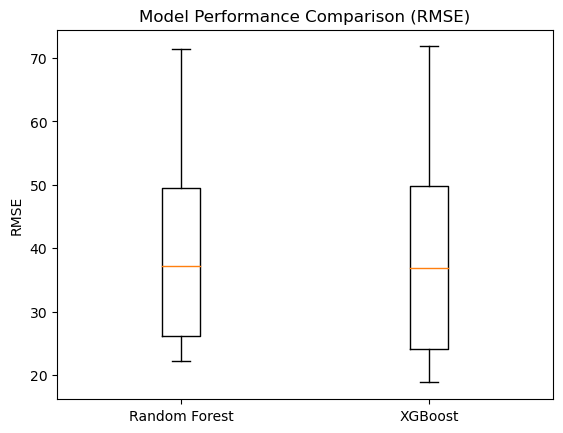

In [82]:
from scipy.stats import ttest_rel
import numpy as np
import matplotlib.pyplot as plt

# Performance metrics for Random Forest and XGBoost
rf_rmse = np.array([37.13362449, 49.47754227, 22.15535297, 26.08745447, 71.49063808])  
xgb_rmse = np.array([24.11267157, 49.8807916 , 18.80703599, 36.82104735, 71.81398348])   

# Paired t-test
t_stat, p_value = ttest_rel(rf_rmse, xgb_rmse)
print(f"Paired t-test results: t-statistic = {t_stat}, p-value = {p_value}")

# Interpretation
if p_value < 0.05:
    print("The difference in performance is statistically significant.")
else:
    print("The difference in performance is not statistically significant.")

# Confidence Interval Calculation
diff = rf_rmse - xgb_rmse
mean_diff = np.mean(diff)
std_error = np.std(diff, ddof=1) / np.sqrt(len(diff))
confidence_interval = [mean_diff - 1.96 * std_error, mean_diff + 1.96 * std_error]
print(f"Confidence Interval for the difference: {confidence_interval}")

# Visualize Differences
plt.boxplot([rf_rmse, xgb_rmse], labels=['Random Forest', 'XGBoost'])
plt.title('Model Performance Comparison (RMSE)')
plt.ylabel('RMSE')
plt.show()
